In [9]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
import clawpack.petclaw as pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans


%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use(['dark_background'])
#plt.style.use('presentation')

In [12]:
filepath = '../Paper_3/flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def get_bathymetry(filepath, resolution=1):
    retval = collections.OrderedDict()
    z = []
    with open(filepath) as f:
        for line in f:
            values = line.split()
            if is_number(values[0])==False:
                if float(values[1]).is_integer():
                    retval[values[0]]=int(values[1])
                else:
                    retval[values[0]]=float(values[1])
            else:
                z.append(float(values[0]))
    z = np.array(z)
    print('Z: {0}'.format(len(z)))
    xmax = float(retval['nrows']) * retval['cellsize']
    nx = retval['nrows']
    dx = retval['cellsize']
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    x = np.linspace(0, nx*dx, num=len(z))
    f = interp1d(x, z)
    xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
    znew = f(xnew)
    nx = len(xnew)

    return znew,xnew

Z: 87
Grid dx = 0.0075
Grid nx = 348
2019-04-13 02:24:58,767 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-13 02:24:59,593 INFO CLAW: Solution 1 computed for time t=13.333333
2019-04-13 02:25:00,468 INFO CLAW: Solution 2 computed for time t=26.666667
2019-04-13 02:25:01,384 INFO CLAW: Solution 3 computed for time t=40.000000
2019-04-13 02:25:02,346 INFO CLAW: Solution 4 computed for time t=53.333333
2019-04-13 02:25:03,360 INFO CLAW: Solution 5 computed for time t=66.666667
2019-04-13 02:25:04,319 INFO CLAW: Solution 6 computed for time t=80.000000
2019-04-13 02:25:05,287 INFO CLAW: Solution 7 computed for time t=93.333333
2019-04-13 02:25:06,261 INFO CLAW: Solution 8 computed for time t=106.666667
2019-04-13 02:25:07,252 INFO CLAW: Solution 9 computed for time t=120.000000
2019-04-13 02:25:08,237 INFO CLAW: Solution 10 computed for time t=133.333333
2019-04-13 02:25:09,395 INFO CLAW: Solution 11 computed for time t=146.666667
2019-04-13 02:25:10,562 INFO CLAW: Solution 12

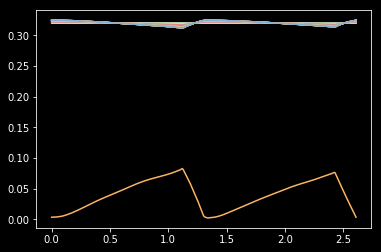

In [113]:

z,x = get_bathymetry(filepath,4)

sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=10000)
sws.set_state_domain(x,z)
sws.set_mannings_source_term(mannings=0.025, slope=1.26/1000.)
sws.set_boundary_conditions()
sws.set_inital_conditions(0.32, 0.0)
sws.set_controller(tfinal=200., num_output_times=15)
sws.run()
cntrl = sws.get_controller()

for i in range(cntrl.num_output_times):
    surf = cntrl.frames[i].q[0,:] + z
    plt.plot(x,surf)
plt.plot(x,z)

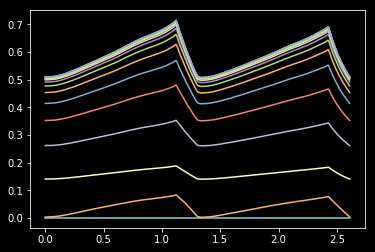

In [114]:
for i in range(cntrl.num_output_times):
    depth = cntrl.frames[i].q[0,:]
    u = cntrl.frames[i].q[1,:]/depth
    plt.plot(x,u)
plt.plot(x,z)

Z: 87
Grid dx = 0.03
Grid nx = 87
2019-04-13 02:40:59,792 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-13 02:41:00,503 INFO CLAW: Solution 1 computed for time t=13.333333
2019-04-13 02:41:01,252 INFO CLAW: Solution 2 computed for time t=26.666667
2019-04-13 02:41:02,009 INFO CLAW: Solution 3 computed for time t=40.000000
2019-04-13 02:41:02,862 INFO CLAW: Solution 4 computed for time t=53.333333
2019-04-13 02:41:03,717 INFO CLAW: Solution 5 computed for time t=66.666667
2019-04-13 02:41:04,745 INFO CLAW: Solution 6 computed for time t=80.000000
2019-04-13 02:41:05,549 INFO CLAW: Solution 7 computed for time t=93.333333
2019-04-13 02:41:06,363 INFO CLAW: Solution 8 computed for time t=106.666667
2019-04-13 02:41:07,203 INFO CLAW: Solution 9 computed for time t=120.000000
2019-04-13 02:41:07,996 INFO CLAW: Solution 10 computed for time t=133.333333
2019-04-13 02:41:08,784 INFO CLAW: Solution 11 computed for time t=146.666667
2019-04-13 02:41:09,610 INFO CLAW: Solution 12 co

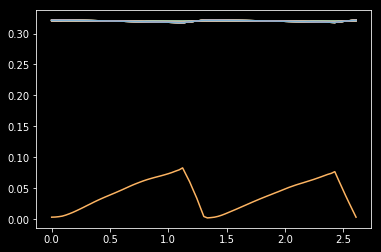

In [160]:
z,x = get_bathymetry(filepath,1)

sws = shallow_water_solver(kernel_language='Python')
sws.set_solver(max_steps=10000)
sws.set_state_domain(x,z)
sws.set_chezy_source_term(ks=0.003, slope=1.26/1000.)
sws.set_boundary_conditions()
sws.set_inital_conditions(0.32, 0.0)
sws.set_controller(tfinal=200., num_output_times=15)
sws.run()
cntrl = sws.get_controller()

for i in range(cntrl.num_output_times):
    surf = cntrl.frames[i].q[0,:] + z
    plt.plot(x,surf)
plt.plot(x,z)

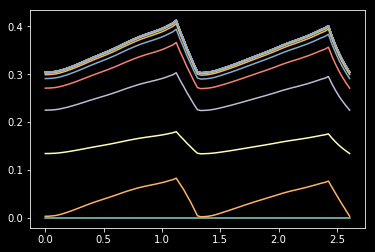

In [161]:
for i in range(cntrl.num_output_times):
    depth = cntrl.frames[i].q[0,:]
    u = cntrl.frames[i].q[1,:]/depth
    plt.plot(x,u)
plt.plot(x,z)

In [164]:
ks = 0.001
Bs = 8.5
kappa = 0.4
cf = ((1./kappa)*np.log(0.368*cntrl.frames[cntrl.num_output_times].q[0,:]/ks) + Bs)
b=0.76
R = b*cntrl.frames[cntrl.num_output_times].q[0,:]/(b + 2*cntrl.frames[cntrl.num_output_times].q[0,:])
n = R**(1/6.)/cf
n

array([0.03658472, 0.03658541, 0.03658762, 0.03659096, 0.03659732,
       0.03660522, 0.03661389, 0.03662372, 0.03663397, 0.03664462,
       0.0366557 , 0.03666642, 0.03667756, 0.03668797, 0.03669802,
       0.03670771, 0.03671704, 0.0367264 , 0.03673578, 0.03674559,
       0.03675542, 0.03676569, 0.03677599, 0.03678593, 0.0367951 ,
       0.03680391, 0.03681234, 0.03682   , 0.03682687, 0.03683336,
       0.03683947, 0.03684559, 0.03685213, 0.0368591 , 0.0368669 ,
       0.03687596, 0.03688423, 0.03689747, 0.03685104, 0.03680604,
       0.03675331, 0.03670247, 0.03664501, 0.03658912, 0.0365804 ,
       0.03658222, 0.0365848 , 0.03658965, 0.03659639, 0.03660466,
       0.03661371, 0.03662278, 0.03663188, 0.03664138, 0.03665091,
       0.03666046, 0.03667005, 0.03667966, 0.03668891, 0.03669818,
       0.0367071 , 0.03671603, 0.03672461, 0.0367336 , 0.03674222,
       0.03675126, 0.03676032, 0.03676942, 0.03677735, 0.03678531,
       0.03679249, 0.03679929, 0.03680651, 0.03681375, 0.03682

Grid dx = 0.03
Grid nx = 87
2019-04-13 02:53:58,178 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-13 02:53:59,058 INFO CLAW: Solution 1 computed for time t=13.333333
2019-04-13 02:53:59,844 INFO CLAW: Solution 2 computed for time t=26.666667
2019-04-13 02:54:00,636 INFO CLAW: Solution 3 computed for time t=40.000000
2019-04-13 02:54:01,472 INFO CLAW: Solution 4 computed for time t=53.333333
2019-04-13 02:54:02,225 INFO CLAW: Solution 5 computed for time t=66.666667
2019-04-13 02:54:03,011 INFO CLAW: Solution 6 computed for time t=80.000000
2019-04-13 02:54:03,798 INFO CLAW: Solution 7 computed for time t=93.333333
2019-04-13 02:54:04,606 INFO CLAW: Solution 8 computed for time t=106.666667
2019-04-13 02:54:05,385 INFO CLAW: Solution 9 computed for time t=120.000000
2019-04-13 02:54:06,177 INFO CLAW: Solution 10 computed for time t=133.333333
2019-04-13 02:54:06,964 INFO CLAW: Solution 11 computed for time t=146.666667
2019-04-13 02:54:07,753 INFO CLAW: Solution 12 computed

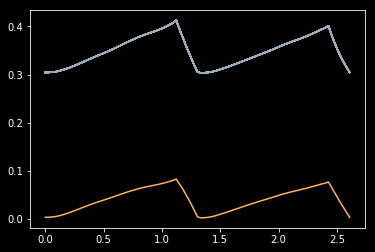

In [166]:
sws = shallow_water_solver(kernel_language='Python')
sws.set_solver(max_steps=10000)
sws.set_state_domain(x,z)
sws.set_chezy_source_term(ks=0.003, slope=1.26/1000.)
sws.set_boundary_conditions()
sws.set_inital_conditions(0.32, 0.0)
sws.set_conditions_from_previous(cntrl.frames[cntrl.num_output_times].q[0,:], cntrl.frames[cntrl.num_output_times].q[1,:])
sws.set_controller(tfinal=200., num_output_times=15)
sws.run()
cntrl = sws.get_controller()

for i in range(cntrl.num_output_times):
    depth = cntrl.frames[i].q[0,:]
    u = cntrl.frames[i].q[1,:]/depth
    plt.plot(x,u)
plt.plot(x,z)